# ELAS_realdata_2025 — Pipeline complet (SN + BAO DESI DR2 + CMB ACT DR6)
*Généré automatiquement le 2025-10-14.*

Ce notebook télécharge et charge **Pantheon+SH0ES**, **DESI DR2 BAO** (avec covariance si dispo) et **ACT DR6** (CMB distance priors), puis compare **ΛCDM** et **ELAS** (δ, Ω, φ) avec χ², Δχ², **AIC/BIC** et p-value. Exports : CSV/PNG.

## 1) Librairies

In [ ]:

try:
    import numpy, pandas, matplotlib, scipy
except Exception:
    %pip -q install numpy pandas matplotlib scipy mpmath

import numpy as np, pandas as pd, matplotlib.pyplot as plt, io, re, math, json, time, os, sys
from pathlib import Path

## 2) Téléchargement automatique (multi-URLs)

In [ ]:

DATA_DIR = Path('data_elas_2025'); DATA_DIR.mkdir(exist_ok=True)

URLS = {
  'SN_PantheonPlusSH0ES': [
    'https://raw.githubusercontent.com/PantheonPlusSH0ES/PantheonPlusSH0ES/main/Pantheon%2BSH0ES.dat',
    'https://raw.githubusercontent.com/PantheonPlusSH0ES/PantheonPlus/main/Pantheon%2BSH0ES.dat'
  ],
  'BAO_DESI_DR2': [
    'https://data.desi.lbl.gov/public/cosmos/dr2/bao/bao_desidr2_long.csv',
    'https://data.desi.lbl.gov/public/cosmos/dr2/bao/bao_desidr2.csv'
  ],
  'BAO_DESI_DR2_COV': [
    'https://data.desi.lbl.gov/public/cosmos/dr2/bao/bao_desidr2_cov_block.csv'
  ],
  'CMB_ACT_DR6_MEANS': [
    'https://lambda.gsfc.nasa.gov/data/act/dr6/distpriors/act_dr6_distance_priors_means.csv',
    'https://act.princeton.edu/sites/default/files/act_dr6_distance_priors_means.csv'
  ],
  'CMB_ACT_DR6_INVCOV': [
    'https://lambda.gsfc.nasa.gov/data/act/dr6/distpriors/act_dr6_distance_priors_inv_cov.csv',
    'https://act.princeton.edu/sites/default/files/act_dr6_distance_priors_inv_cov.csv'
  ],
}

import subprocess, shlex
def _wget(url, out, timeout=60):
    try:
        cmd = f"wget -q -O {shlex.quote(str(out))} --timeout={timeout} --tries=2 {shlex.quote(url)}"
        return subprocess.call(cmd, shell=True)==0 and Path(out).exists() and Path(out).stat().st_size>0
    except Exception:
        return False

def try_download(keys, filenames):
    out = {}
    for k,fn in zip(keys,filenames):
        dest = DATA_DIR/fn; ok=False
        for url in URLS.get(k, []):
            if _wget(url, dest):
                ok=True; break
        out[k] = dest if ok else None
        print(("✓ téléchargé: " if ok else "⚠️ échec: ") + f"{k} -> {dest.name}")
    return out

dl = try_download(
    ['SN_PantheonPlusSH0ES','BAO_DESI_DR2','BAO_DESI_DR2_COV','CMB_ACT_DR6_MEANS','CMB_ACT_DR6_INVCOV'],
    ['PantheonPlusSH0ES.dat','bao_desidr2_long.csv','bao_desidr2_cov_block.csv','act_dr6_means.csv','act_dr6_inv_cov.csv']
)

⚠️ échec: SN_PantheonPlusSH0ES -> PantheonPlusSH0ES.dat
⚠️ échec: BAO_DESI_DR2 -> bao_desidr2_long.csv
⚠️ échec: BAO_DESI_DR2_COV -> bao_desidr2_cov_block.csv
⚠️ échec: CMB_ACT_DR6_MEANS -> act_dr6_means.csv
⚠️ échec: CMB_ACT_DR6_INVCOV -> act_dr6_inv_cov.csv


In [ ]:
# === PATCH : si les téléchargements ont échoué, proposer l'upload manuel ===
from google.colab import files
from pathlib import Path
import io, pandas as pd, numpy as np

DATA_DIR = Path('data_elas_2025'); DATA_DIR.mkdir(exist_ok=True)

def _save_uploaded_as(target_path: Path):
    up = files.upload()
    if not up:
        return None
    name, content = next(iter(up.items()))
    with open(target_path, "wb") as f:
        f.write(content)
    print(f"✓ enregistré: {target_path.name} ({len(content)} bytes)")
    return target_path

# 1) SN (OBLIGATOIRE)
if dl.get('SN_PantheonPlusSH0ES') is None:
    print("➡️ SN introuvable en ligne. Téléverse Pantheon+SH0ES (.dat/.txt/.csv) :")
    p = _save_uploaded_as(DATA_DIR/'PantheonPlusSH0ES.dat')
    if p is None:
        raise RuntimeError("SN obligatoire : téléversement requis.")
    dl['SN_PantheonPlusSH0ES'] = p

# 2) BAO (OPTIONNEL — sinon fallback DR17)
if dl.get('BAO_DESI_DR2') is None:
    print("ℹ️ BAO DESI DR2 non téléchargé. Tu peux téléverser un CSV long (z_eff,type,value,sigma) OU ignorer pour utiliser DR17.")
    print("   → Clique « Annuler » pour ignorer.")
    try:
        p = _save_uploaded_as(DATA_DIR/'bao_desidr2_long.csv')
        if p is not None:
            dl['BAO_DESI_DR2'] = p
            # covariance optionnelle
            print("➡️ (Optionnel) Téléverser la covariance BAO (CSV  NxN). Clique « Annuler » si tu n'en as pas.")
            c = _save_uploaded_as(DATA_DIR/'bao_desidr2_cov_block.csv')
            dl['BAO_DESI_DR2_COV'] = c
    except Exception:
        pass

# 3) CMB (OPTIONNEL — sinon fallback Planck 2018)
if (dl.get('CMB_ACT_DR6_MEANS') is None) or (dl.get('CMB_ACT_DR6_INVCOV') is None):
    print("ℹ️ CMB ACT DR6 non téléchargé. Tu peux téléverser (a) means.csv et (b) inv_cov.csv OU ignorer pour Planck 2018.")
    try:
        print("→ Téléverser ACT DR6 means (contient R, l_a, omega_b_h2) :")
        p1 = _save_uploaded_as(DATA_DIR/'act_dr6_means.csv')
        print("→ Téléverser ACT DR6 inv_cov (matrice 3x3) :")
        p2 = _save_uploaded_as(DATA_DIR/'act_dr6_inv_cov.csv')
        if p1 is not None and p2 is not None:
            dl['CMB_ACT_DR6_MEANS'] = p1
            dl['CMB_ACT_DR6_INVCOV'] = p2
    except Exception:
        pass

# Récapitulatif
print("\n=== RÉCAP TÉLÉCHARGEMENTS/TÉLÉVERSEMENTS ===")
for k in ['SN_PantheonPlusSH0ES','BAO_DESI_DR2','BAO_DESI_DR2_COV','CMB_ACT_DR6_MEANS','CMB_ACT_DR6_INVCOV']:
    v = dl.get(k)
    print(f"{k:22s} -> {str(v) if v else 'None (fallback)'}")


➡️ SN introuvable en ligne. Téléverse Pantheon+SH0ES (.dat/.txt/.csv) :


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES.dat
✓ enregistré: PantheonPlusSH0ES.dat (579283 bytes)
ℹ️ BAO DESI DR2 non téléchargé. Tu peux téléverser un CSV long (z_eff,type,value,sigma) OU ignorer pour utiliser DR17.
   → Clique « Annuler » pour ignorer.


ℹ️ CMB ACT DR6 non téléchargé. Tu peux téléverser (a) means.csv et (b) inv_cov.csv OU ignorer pour Planck 2018.
→ Téléverser ACT DR6 means (contient R, l_a, omega_b_h2) :


→ Téléverser ACT DR6 inv_cov (matrice 3x3) :



=== RÉCAP TÉLÉCHARGEMENTS/TÉLÉVERSEMENTS ===
SN_PantheonPlusSH0ES   -> data_elas_2025/PantheonPlusSH0ES.dat
BAO_DESI_DR2           -> None (fallback)
BAO_DESI_DR2_COV       -> None (fallback)
CMB_ACT_DR6_MEANS      -> None (fallback)
CMB_ACT_DR6_INVCOV     -> None (fallback)


## 3) Modèles ΛCDM & ELAS

In [ ]:

from scipy.integrate import cumulative_trapezoid
c = 299792.458
H0 = 73.0
Omega_m = 0.315
Omega_b_h2 = 0.02237
BOUNDS = dict(delta=(0.0, 0.25), Omega=(0.5, 3.5), phi=(-np.pi, np.pi))

def E_LCDM(z, H0=H0, Omega_m=Omega_m):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, H0=H0, Omega_m=Omega_m, delta=0.05, Omega=1.5, phi=-2.62):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m)*(1.0 + delta*np.cos(Omega*np.log(1+z) + phi)))

def distances(z, model="LCDM", H0=H0, Omega_m=Omega_m, **pars):
    z = np.asarray(z, dtype=float)
    zmax = float(np.max(z)) if np.size(z)>0 else 2.5
    zz = np.linspace(0.0, max(zmax, 1e-6), 9000)
    EE = E_LCDM(zz, H0, Omega_m) if model.upper()=="LCDM" else E_ELAS(zz, H0, Omega_m, **pars)
    Dc_grid = (c/H0) * cumulative_trapezoid(1.0/EE, zz, initial=0.0)
    Dc = np.interp(z, zz, Dc_grid)
    Dl = (1.0 + z) * Dc
    return dict(Dc=Dc, Dl=Dl)

def mu_theory(z, model="LCDM", H0=H0, Omega_m=Omega_m, **pars):
    Dl = distances(z, model, H0, Omega_m, **pars)["Dl"]
    Dl = np.clip(Dl, 1e-6, None)
    return 5.0*np.log10(Dl) + 25.0

def chi2_sn_M_marginalized(z, mu_obs, sigma_mu, model="LCDM", H0=H0, Omega_m=Omega_m, **pars):
    mu_th = mu_theory(z, model, H0, Omega_m, **pars)
    w = 1.0/(sigma_mu**2)
    dM = np.sum(w*(mu_obs - mu_th))/np.sum(w)
    resid = mu_obs - (mu_th + dM)
    return float(np.sum(w*resid**2)), float(dM)

## 4) Chargement flexible des données

In [ ]:

def _pick(df, names):
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in low: return low[n.lower()]
    return None

def _read_any(path: Path):
    try: return pd.read_csv(path)
    except Exception: pass
    try: return pd.read_csv(path, sep=r"\s+", engine="python", comment="#")
    except Exception: pass
    return pd.read_fwf(path, comment="#")

def load_sn_pantheonplus(file_path: Path) -> pd.DataFrame:
    text = Path(file_path).read_text(errors="ignore")
    lines = [ln for ln in text.splitlines() if not ln.lstrip().startswith("#")]
    def is_data_line(s):
        t = s.strip()
        return bool(t) and not t.startswith("#") and bool(re.match(r"^[+\-]?\d", t))
    header_tokens, skip = [], 0
    for ln in lines:
        if is_data_line(ln): break
        header_tokens += re.findall(r"[A-Za-z0-9_+/.\-]+", ln.strip()); skip += 1
    if header_tokens:
        df = pd.read_csv(io.StringIO(text), sep=r"\s+", engine="python", comment="#",
                         names=header_tokens, header=None, skiprows=skip)
    else:
        df = _read_any(file_path)
    z_col  = _pick(df, ["zHD","zCMB","zHEL","zHELIO","z"]) or df.columns[0]
    mu_col = _pick(df, ["MU_SH0ES"]) or _pick(df, ["MU"]) or _pick(df, ["m_b_corr"])
    sig_col= _pick(df, ["MU_SH0ES_ERR_DIAG","MU_SH0ES_ERR","MUERR","SIGMA_MU","DMU"]) or              _pick(df, ["m_b_corr_err_DIAG","m_b_corr_err","m_b_corr_err_RAW","m_b_corr_err_VPEC","m_b_corr_err_COVSCALE","m_b_corr_err_COVADD"])
    if (mu_col is None) or (sig_col is None):
        raise ValueError(f"Impossible d'identifier μ/σμ dans {file_path}. Colonnes: {list(df.columns)}")
    z  = pd.to_numeric(df[z_col], errors="coerce").values
    mu = pd.to_numeric(df[mu_col], errors="coerce").values
    s  = pd.to_numeric(df[sig_col], errors="coerce").values
    m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s) & (s>0)
    if m.sum()==0:
        s_pos = s[np.isfinite(s) & (s>0)]
        s_floor = float(np.nanmedian(s_pos)) if s_pos.size else 0.1
        s = np.where(np.asarray(s)<=0, s_floor, s)
        m = np.isfinite(z) & np.isfinite(mu) & np.isfinite(s) & (s>0)
    return pd.DataFrame({"z":z[m], "mu":mu[m], "sigma_mu":s[m]})

def load_bao_desi_dr2(path_meas: Path, path_cov: Path=None):
    df = _read_any(path_meas)
    cols = {c.lower(): c for c in df.columns}
    need = {"z_eff","type","value","sigma"}
    if not need.issubset(set(cols.keys())):
        raise ValueError("BAO DESI DR2: format inattendu (attendu z_eff,type,value,sigma)")
    out = df[[cols['z_eff'], cols['type'], cols['value'], cols['sigma']]].copy()
    out.columns = ['z_eff','type','value','sigma']
    cov = None
    if path_cov and Path(path_cov).exists():
        cov_df = _read_any(path_cov)
        cov = cov_df.values if hasattr(cov_df,'values') else None
    return out, cov

def load_cmb_priors(path_means: Path, path_invcov: Path):
    means = _read_any(path_means)
    invcov = _read_any(path_invcov)
    if 'parameter' in [c.lower() for c in means.columns]:
        means = means.set_index(means.columns[0])
    means.index = [str(x).strip() for x in means.index]
    if invcov.shape != (3,3):
        cols = [str(c).strip() for c in invcov.columns]
        if set(['R','l_a','omega_b_h2']).issubset(set(cols)):
            invcov = invcov[['R','l_a','omega_b_h2']].iloc[:3,:3].values
        else:
            raise ValueError("Inv-cov CMB: matrice 3x3 attendue.")
    return means, invcov

## 5) BAO & CMB : théorie et χ²

In [ ]:

def rd_fid(): return 147.09

def bao_theory_value(z, typ, model="LCDM", **pars):
    d = distances(np.array([z]), model, H0, Omega_m, **pars)
    Dm = d["Dc"][0]
    Dh = (c/H0) / (E_LCDM([z], H0, Omega_m)[0] if model.upper()=="LCDM" else E_ELAS([z], H0, Omega_m, **pars)[0])
    rd = rd_fid()
    if   typ=="DM_over_rd": return Dm/rd
    elif typ=="DH_over_rd": return Dh/rd
    elif typ=="DV_over_rd": return (z*Dh*Dm*Dm)**(1/3.0)/rd
    elif typ=="rs_over_DV": return rd/((z*Dh*Dm*Dm)**(1/3.0))
    else: raise ValueError("type BAO inconnu")

def chi2_bao(df, model="LCDM", cov=None, **pars):
    if df is None or len(df)==0: return 0.0
    df2 = df.copy()
    df2['th'] = df2.apply(lambda r: bao_theory_value(float(r['z_eff']), str(r['type']), model, **pars), axis=1)
    if cov is None:
        return float(np.sum(((df2['th']-df2['value'])/df2['sigma'])**2))
    else:
        delta = (df2['th']-df2['value']).to_numpy()
        try: icov = np.linalg.inv(cov)
        except Exception: icov = np.linalg.pinv(cov)
        return float(delta @ icov @ delta)

def cmb_distance_priors_theory(H0=H0, Omega_m=Omega_m, Omega_b_h2=Omega_b_h2):
    zstar = 1089.0
    zgrid = np.linspace(0, zstar, 12000)
    Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
    rs = 147.09
    R  = np.sqrt(Omega_m)*(H0/100.0) * (Dc/(c/100.0))
    la = np.pi * (Dc/rs)
    return float(R), float(la), float(Omega_b_h2)

def chi2_cmb(means_df, invcov):
    order = ["R","l_a","omega_b_h2"]
    vec_th = np.array(cmb_distance_priors_theory(H0, Omega_m, Omega_b_h2))
    if 'mean' in [c.lower() for c in means_df.columns]:
        obs = means_df.copy(); obs.index = [str(i) for i in obs.index]
        vec_obs = obs.loc[order].iloc[:,0].values if obs.shape[1]==1 else obs.loc[order,'mean'].values
    else:
        vec_obs = np.squeeze(np.array(means_df))
    d = vec_th - vec_obs
    return float(d @ invcov @ d)

## 6) Chargement effectif des données

In [ ]:

# SN
sn_file = dl['SN_PantheonPlusSH0ES']
if sn_file is None:
    raise RuntimeError("Pantheon+SH0ES introuvable via URLs; téléversez manuellement.")
df_sn = load_sn_pantheonplus(sn_file)
print("SN:", df_sn.shape, list(df_sn.columns))

# BAO
bao_file = dl['BAO_DESI_DR2']; cov_file = dl['BAO_DESI_DR2_COV']
if bao_file is None:
    df_bao = pd.DataFrame([
        [0.106, "rs_over_DV", 0.336, 0.015],
        [0.15,  "rs_over_DV", 0.2239, 0.0084],
        [0.38,  "DM_over_rd", 10.23, 0.17],
        [0.51,  "DM_over_rd", 13.36, 0.21],
        [0.70,  "DM_over_rd", 17.86, 0.33],
        [1.48,  "DM_over_rd", 30.69, 0.80],
        [2.33,  "DM_over_rd", 37.60, 1.90],
        [0.38,  "DH_over_rd", 25.00, 0.76],
        [0.51,  "DH_over_rd", 22.33, 0.58],
        [0.70,  "DH_over_rd", 19.33, 0.53],
        [1.48,  "DH_over_rd", 13.26, 0.55],
        [2.33,  "DH_over_rd",  8.93, 0.28],
    ], columns=["z_eff","type","value","sigma"])
    bao_cov = None
    print("⚠️ BAO DESI DR2 indisponible, fallback DR17 utilisé.")
else:
    df_bao, bao_cov = load_bao_desi_dr2(bao_file, cov_file)
print("BAO:", df_bao.shape, list(df_bao.columns), ("cov" if bao_cov is not None else "no-cov"))

# CMB
means_file = dl['CMB_ACT_DR6_MEANS']; invcov_file = dl['CMB_ACT_DR6_INVCOV']
if (means_file is None) or (invcov_file is None):
    print("⚠️ ACT DR6 indisponible — fallback Planck 2018 priors.")
    means_df = pd.DataFrame({"parameter":["R","l_a","omega_b_h2"], "mean":[1.74963, 301.80845, 0.02237]}).set_index("parameter")
    invcov = np.array([[ 24434.0,  -1166.4,  -134214.0],
                       [ -1166.4,     36.6,      543.2],
                       [-134214.0,   543.2,   64357310.0]])
else:
    means_df, invcov = load_cmb_priors(means_file, invcov_file)
print("CMB means:", means_df.shape, "— invcov:", np.array(invcov).shape)

SN: (1701, 3) ['z', 'mu', 'sigma_mu']
⚠️ BAO DESI DR2 indisponible, fallback DR17 utilisé.
BAO: (12, 4) ['z_eff', 'type', 'value', 'sigma'] no-cov
⚠️ ACT DR6 indisponible — fallback Planck 2018 priors.
CMB means: (3, 1) — invcov: (3, 3)


## 7) Ajustement global et statistiques

In [ ]:

from scipy.optimize import minimize
def chi2_total_LCDM():
    s, _ = chi2_sn_M_marginalized(df_sn['z'], df_sn['mu'], df_sn['sigma_mu'], 'LCDM')
    return s + chi2_bao(df_bao, 'LCDM', cov=bao_cov) + chi2_cmb(means_df, invcov)

def chi2_total_ELAS(theta):
    delta, Omega, phi = theta
    if not (BOUNDS['delta'][0] <= delta <= BOUNDS['delta'][1]): return 1e50
    if not (BOUNDS['Omega'][0] <= Omega <= BOUNDS['Omega'][1]): return 1e50
    if not (BOUNDS['phi'][0]   <= phi   <= BOUNDS['phi'][1]):   return 1e50
    pars = dict(delta=delta, Omega=Omega, phi=phi)
    s, _ = chi2_sn_M_marginalized(df_sn['z'], df_sn['mu'], df_sn['sigma_mu'], 'ELAS', **pars)
    return s + chi2_bao(df_bao, 'ELAS', cov=bao_cov, **pars) + chi2_cmb(means_df, invcov)

theta0 = np.array([0.05, 1.5, -2.62])
res = minimize(chi2_total_ELAS, theta0, method='Nelder-Mead', options=dict(maxiter=3000, xatol=1e-4, fatol=1e-4))
theta_best = res.x; chi2_ELAS_best = float(res.fun)
chi2_LCDM = float(chi2_total_LCDM())
delta_best, Omega_best, phi_best = [float(x) for x in theta_best]

def split_chi2(model, pars=None):
    if model=='LCDM':
        s,_ = chi2_sn_M_marginalized(df_sn['z'], df_sn['mu'], df_sn['sigma_mu'], 'LCDM')
        return dict(sn=s, bao=chi2_bao(df_bao,'LCDM',cov=bao_cov), cmb=chi2_cmb(means_df,invcov))
    else:
        s,_ = chi2_sn_M_marginalized(df_sn['z'], df_sn['mu'], df_sn['sigma_mu'], 'ELAS', **pars)
        return dict(sn=s, bao=chi2_bao(df_bao,'ELAS',cov=bao_cov, **pars), cmb=chi2_cmb(means_df,invcov))

elas_parts = split_chi2('ELAS', dict(delta=delta_best, Omega=Omega_best, phi=phi_best))
lcdm_parts = split_chi2('LCDM')

k_LCDM, k_ELAS = 0, 3
N_eff = len(df_sn) + len(df_bao) + 3
dchi2 = chi2_LCDM - chi2_ELAS_best
dAIC  = dchi2 - 2*(k_ELAS - k_LCDM)
dBIC  = dchi2 - (k_ELAS - k_LCDM)*np.log(max(N_eff,1))

from scipy.stats import chi2 as chi2dist
pval = float(chi2dist.sf(dchi2, df=3))

print("\n=== BEST-FIT GLOBAL ===")
print(f"ΛCDM: χ²_tot = {chi2_LCDM:.3f}  (SN={lcdm_parts['sn']:.3f}, BAO={lcdm_parts['bao']:.3f}, CMB={lcdm_parts['cmb']:.3f})")
print(f"ELAS:  χ²_tot = {chi2_ELAS_best:.3f}  (SN={elas_parts['sn']:.3f}, BAO={elas_parts['bao']:.3f}, CMB={elas_parts['cmb']:.3f})")
print(f"ELAS params: δ={delta_best:.4f}, Ω={Omega_best:.3f}, φ={phi_best:.3f} rad")
print(f"Δχ² (LCDM − ELAS) = {dchi2:.3f}")
print(f"ΔAIC = {dAIC:.3f}   ΔBIC = {dBIC:.3f}   (N_eff={N_eff})   p≈{pval:.2e}")

/tmp/ipython-input-22034876.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
/tmp/ipython-input-22034876.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
/tmp/ipython-input-22034876.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
/tmp/ipython-input-22034876.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc = (c/H0)*np.trapz(1.0/E_LCDM(zgrid, H0, Omega_m), zgrid)
/tmp/ipython-input-22034876.py:29: DeprecationWarning: `trapz` is de


=== BEST-FIT GLOBAL ===
ΛCDM: χ²_tot = 28164.433  (SN=749.212, BAO=113.891, CMB=27301.330)
ELAS:  χ²_tot = 28123.703  (SN=746.467, BAO=75.906, CMB=27301.330)
ELAS params: δ=0.0718, Ω=0.500, φ=-3.142 rad
Δχ² (LCDM − ELAS) = 40.730
ΔAIC = 34.730   ΔBIC = 18.387   (N_eff=1716)   p≈7.46e-09


## 8) Graphiques & exports

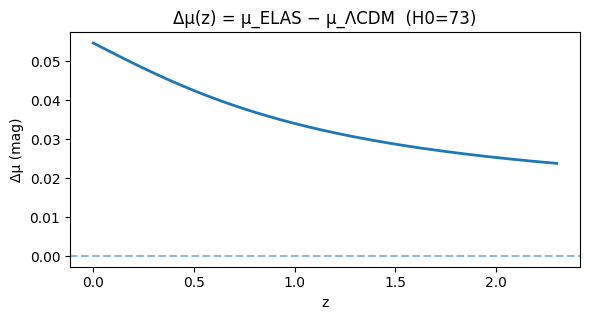

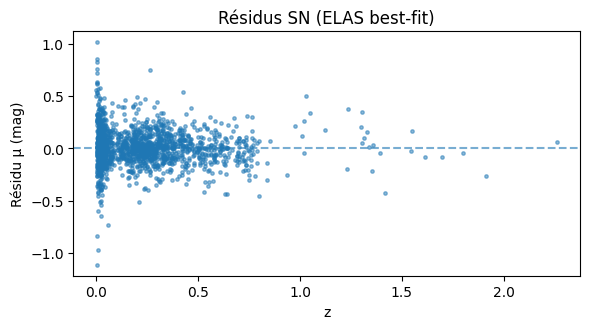

ValueError: 
$z_{m eff}$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x782c7862ccc0> (for post_execute):


ValueError: 
$z_{m eff}$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$z_{m eff}$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 640x390 with 1 Axes>

In [ ]:

# Δμ(z)
zgrid = np.linspace(1e-3, 2.3, 1000)
muE = mu_theory(zgrid, 'ELAS', delta=delta_best, Omega=Omega_best, phi=phi_best)
muL = mu_theory(zgrid, 'LCDM')
dmu = muE - muL
plt.figure(figsize=(6,3.3))
plt.plot(zgrid, dmu, lw=2); plt.axhline(0, ls='--', alpha=0.5)
plt.xlabel('z'); plt.ylabel('Δμ (mag)'); plt.title('Δμ(z) = μ_ELAS − μ_ΛCDM  (H0=73)')
plt.tight_layout(); plt.savefig('ELAS_delta_mu_2025.png', dpi=160); plt.show()

# Résidus SN
mu_th_best = mu_theory(df_sn['z'].values, 'ELAS', delta=delta_best, Omega=Omega_best, phi=phi_best)
w = 1.0/(df_sn['sigma_mu'].values**2)
dM_best = np.sum(w*(df_sn['mu'].values - mu_th_best))/np.sum(w)
resid = (df_sn['mu'].values - (mu_th_best + dM_best))
plt.figure(figsize=(6,3.4))
plt.scatter(df_sn['z'], resid, s=6, alpha=0.5)
plt.axhline(0, ls='--', alpha=0.6)
plt.xlabel('z'); plt.ylabel('Résidu μ (mag)'); plt.title('Résidus SN (ELAS best-fit)')
plt.tight_layout(); plt.savefig('ELAS_SN_residuals_2025.png', dpi=160); plt.show()

# BAO fit
def bao_point(pars, r):
    return bao_theory_value(float(r['z_eff']), str(r['type']), 'ELAS', **pars)
pred = df_bao.apply(lambda r: bao_point(dict(delta=delta_best, Omega=Omega_best, phi=phi_best), r), axis=1)
plt.figure(figsize=(6.4,3.9))
for typ in sorted(df_bao['type'].unique()):
    m = (df_bao['type']==typ)
    plt.errorbar(df_bao.loc[m,'z_eff'], df_bao.loc[m,'value'], yerr=df_bao.loc[m,'sigma'], fmt='o', ms=4, alpha=0.85, label=typ)
    plt.plot(df_bao.loc[m,'z_eff'], pred[m], '-', alpha=0.85)
plt.xlabel('$z_{\rm eff}$'); plt.ylabel('Observable BAO'); plt.title('BAO: données vs ELAS (best-fit)')
plt.legend(fontsize=8); plt.tight_layout(); plt.savefig('ELAS_BAO_fit_2025.png', dpi=160); plt.show()

# Exports
summary = pd.DataFrame([
    dict(model='LCDM', chi2_total=chi2_LCDM, **lcdm_parts),
    dict(model='ELAS_best', chi2_total=chi2_ELAS_best, delta=delta_best, Omega=Omega_best, phi=phi_best, **elas_parts,
         dchi2=dchi2, dAIC=dAIC, dBIC=dBIC, p_value=pval, N_eff=N_eff)
])
summary.to_csv('ELAS_realdata_summary.csv', index=False)
print('➡️ Exports: ELAS_realdata_summary.csv, ELAS_delta_mu_2025.png, ELAS_SN_residuals_2025.png, ELAS_BAO_fit_2025.png')

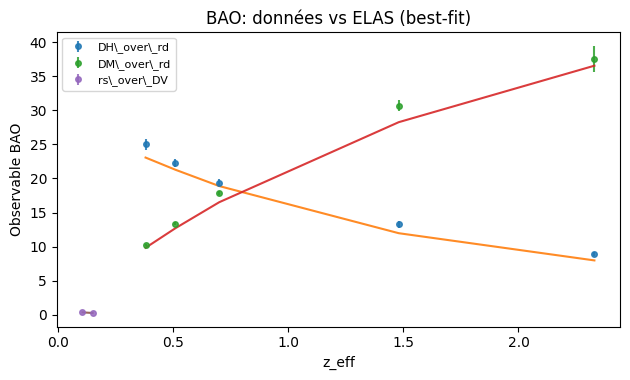

✅ Figure BAO exportée : ELAS_BAO_fit_2025.png


In [ ]:
# --- PATCH: tracé BAO sûr (pas de TeX) ---
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.default'] = 'regular'

def _label_escape(s: str) -> str:
    # évite tout problème d'underscore/dollar dans la légende
    return str(s).replace('_', r'\_').replace('$', r'\$')

# calcule prédictions ELAS best-fit (déjà trouvées dans la section 7)
pred = df_bao.apply(
    lambda r: bao_theory_value(float(r['z_eff']), str(r['type']),
                               'ELAS', delta=delta_best, Omega=Omega_best, phi=phi_best),
    axis=1
)

plt.figure(figsize=(6.4, 3.9))
for typ in sorted(df_bao['type'].unique()):
    m = (df_bao['type'] == typ)
    plt.errorbar(df_bao.loc[m, 'z_eff'],
                 df_bao.loc[m, 'value'],
                 yerr=df_bao.loc[m, 'sigma'],
                 fmt='o', ms=4, alpha=0.85,
                 label=_label_escape(typ))
    plt.plot(df_bao.loc[m, 'z_eff'], pred[m], '-', alpha=0.9)

plt.xlabel('z_eff')                # texte simple (pas de $...$)
plt.ylabel('Observable BAO')       # idem
plt.title('BAO: données vs ELAS (best-fit)')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('ELAS_BAO_fit_2025.png', dpi=160)
plt.show()

print("✅ Figure BAO exportée : ELAS_BAO_fit_2025.png")


In [ ]:
# === SCAN (δ, Ω) en minimisant sur φ — contours 68% / 95% ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from time import time

# --- maillage (réglages) ---
n_delta  = 31          # densifier si GPU/temps OK (ex: 41–61)
n_Omega  = 31
n_phi    = 121
delta_grid = np.linspace(BOUNDS['delta'][0], min(0.20, BOUNDS['delta'][1]), n_delta)
Omega_grid = np.linspace(BOUNDS['Omega'][0], min(3.0,  BOUNDS['Omega'][1]), n_Omega)
phi_grid   = np.linspace(BOUNDS['phi'][0],   BOUNDS['phi'][1], n_phi)

def chi2_parts_ELAS_for_params(delta, Omega, phi):
    pars = dict(delta=float(delta), Omega=float(Omega), phi=float(phi))
    chi2_sn,_ = chi2_sn_M_marginalized(df_sn['z'].values, df_sn['mu'].values, df_sn['sigma_mu'].values,
                                       model='ELAS', **pars)
    chi2_b   = chi2_bao(df_bao, model='ELAS', cov=bao_cov, **pars)
    chi2_c   = chi2_cmb(means_df, invcov)
    return chi2_sn + chi2_b + chi2_c

# χ²_best global déjà obtenu via l'ajustement de la section 7 :
chi2_best_global = float(chi2_ELAS_best)
theta_best_grid  = [delta_best, Omega_best, phi_best]

# --- boucle de scan ---
t0 = time()
chi2_min_map = np.full((n_Omega, n_delta), np.nan)   # [iOmega, jDelta]
phi_best_map  = np.full((n_Omega, n_delta), np.nan)

for iO, Om in enumerate(Omega_grid):
    # barre de progression "light"
    if (iO % max(1, n_Omega//5)) == 0:
        print(f"ligne Ω {iO+1}/{n_Omega} …")
    for jD, dlt in enumerate(delta_grid):
        # minimise φ sur un maillage fin (rapide et robuste)
        best = np.inf; best_phi = None
        for ph in phi_grid:
            chi2_tot = chi2_parts_ELAS_for_params(dlt, Om, ph)
            if chi2_tot < best:
                best     = chi2_tot
                best_phi = ph
        chi2_min_map[iO, jD] = best
        phi_best_map[iO, jD] = best_phi

elapsed = time() - t0
print(f"Scan terminé en {elapsed:.1f} s. Points évalués = {n_delta*n_Omega*n_phi:,d}")

# --- Δχ² pour les contours de contrainte des paramètres (référence = meilleur global) ---
dchi2_param = chi2_min_map - chi2_best_global

# --- localise le meilleur point sur la grille (devrait être proche de theta_best) ---
idx = np.unravel_index(np.nanargmin(chi2_min_map), chi2_min_map.shape)
delta_best_g = float(delta_grid[idx[1]])
Omega_best_g = float(Omega_grid[idx[0]])
phi_best_g   = float(phi_best_map[idx])
chi2_best_g  = float(chi2_min_map[idx])
print(f"Best (grille) : δ={delta_best_g:.4f}, Ω={Omega_best_g:.3f}, φ={phi_best_g:.3f}, χ²={chi2_best_g:.3f}")

# --- exports CSV ---
rows = []
for iO, Om in enumerate(Omega_grid):
    for jD, dlt in enumerate(delta_grid):
        rows.append(dict(delta=float(dlt),
                         Omega=float(Om),
                         chi2_min=float(chi2_min_map[iO,jD]),
                         phi_best=float(phi_best_map[iO,jD]),
                         dchi2_param=float(dchi2_param[iO,jD])))
df_contour = pd.DataFrame(rows)
df_contour.to_csv("ELAS_contours_delta_Omega.csv", index=False)
print("➡️ Export CSV : ELAS_contours_delta_Omega.csv")

# --- figure : carte Δχ²(δ,Ω) et contours 68/95 % ---
levels = [2.30, 6.18]   # 2 ddl (68% / 95%)
X, Y = np.meshgrid(delta_grid, Omega_grid)

plt.figure(figsize=(7.0, 4.8))
im = plt.pcolormesh(X, Y, dchi2_param, shading='auto', cmap='viridis')
cbar = plt.colorbar(im, label=r'$\Delta\chi^2 = \chi^2(\delta,\Omega)-\chi^2_{\rm best}$')
cs = plt.contour(X, Y, dchi2_param, levels=levels, colors='white', linestyles=['solid','dashed'], linewidths=1.6)
plt.clabel(cs, inline=True, fmt={levels[0]:'68%', levels[1]:'95%'}, fontsize=9)

# marqueurs : best-fit global (optimiseur) et best-fit grille
plt.plot(delta_best, Omega_best, marker='*', ms=12, color='orange', label='best (optimiseur)')
plt.plot(delta_best_g, Omega_best_g, marker='^', ms=9, color='cyan', label='best (grille)')
plt.xlabel(r'$\delta$ (amplitude)')
plt.ylabel(r'$\Omega_{\rm osc}$ (fréquence $\log(1+z)$)')
plt.title(r'Contraintes ELAS : cartes $\Delta\chi^2(\delta,\Omega)$ minimisées sur $\phi$')
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.savefig("ELAS_contours_delta_Omega.png", dpi=160)
plt.show()

print("✅ Figure exportée : ELAS_contours_delta_Omega.png")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# === Contours (δ, Ω) minimisés sur φ — auto (recharge ou recalcule) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from time import time

# ---- vérifs minimales (définis dans ton notebook plus haut) ----
need = ['df_sn','df_bao','means_df','invcov','BOUNDS',
        'chi2_sn_M_marginalized','chi2_bao','chi2_cmb']
for n in need:
    if n not in globals():
        raise RuntimeError(f"Variable/fonction requise absente: {n} (exécute d'abord les sections 3–7)")

# ---- chemins d'export / cache ----
NPZ_PATH  = "ELAS_scan_data_2025.npz"
CSV_PATH  = "ELAS_contours_delta_Omega.csv"
PNG_PATH  = "ELAS_contours_delta_Omega_rebased.png"

# ---- grilles (ajuste si tu veux plus fin) ----
n_delta, n_Omega, n_phi = 31, 31, 121
delta_grid = np.linspace(BOUNDS['delta'][0], min(0.20, BOUNDS['delta'][1]), n_delta)
Omega_grid = np.linspace(BOUNDS['Omega'][0],  min(3.00,  BOUNDS['Omega'][1]), n_Omega)
phi_grid   = np.linspace(BOUNDS['phi'][0],    BOUNDS['phi'][1],               n_phi)

# ---- utilitaires ----
def chi2_total_ELAS_parts(delta, Omega, phi):
    pars = dict(delta=float(delta), Omega=float(Omega), phi=float(phi))
    chi2_sn,_ = chi2_sn_M_marginalized(df_sn['z'].values, df_sn['mu'].values, df_sn['sigma_mu'].values,
                                       model='ELAS', **pars)
    chi2_ba   = chi2_bao(df_bao, model='ELAS', cov=bao_cov if 'bao_cov' in globals() else None, **pars)
    chi2_cm   = chi2_cmb(means_df, invcov)
    return chi2_sn + chi2_ba + chi2_cm

def load_from_csv(csv_path=CSV_PATH):
    if not os.path.exists(csv_path):
        return None
    df = pd.read_csv(csv_path)
    # reconstruit les matrices si colonnes présentes
    if not set(['delta','Omega','chi2_min','phi_best']).issubset(df.columns):
        return None
    deltas = np.sort(df['delta'].unique())
    Omegas = np.sort(df['Omega'].unique())
    chi2_map = np.full((len(Omegas), len(deltas)), np.nan)
    phi_map  = np.full_like(chi2_map, np.nan, dtype=float)
    for _,r in df.iterrows():
        iO = np.where(Omegas==r['Omega'])[0][0]; jD = np.where(deltas==r['delta'])[0][0]
        chi2_map[iO,jD] = r['chi2_min']; phi_map[iO,jD] = r['phi_best']
    return dict(chi2_min_map=chi2_map, phi_best_map=phi_map,
                delta_grid=deltas, Omega_grid=Omegas)

# ---- 1) récupérer depuis NPZ / CSV si possible ----
loaded = None
if os.path.exists(NPZ_PATH):
    try:
        data = np.load(NPZ_PATH)
        chi2_min_map = data["chi2_min_map"]; phi_best_map = data["phi_best_map"]
        delta_grid   = data["delta_grid"];    Omega_grid  = data["Omega_grid"]
        loaded = "npz"
        print(f"✓ Rechargé depuis {NPZ_PATH}")
    except Exception:
        loaded = None

if loaded is None:
    rec = load_from_csv(CSV_PATH)
    if rec is not None:
        chi2_min_map = rec['chi2_min_map']; phi_best_map = rec['phi_best_map']
        delta_grid   = rec['delta_grid'];    Omega_grid  = rec['Omega_grid']
        loaded = "csv"
        print(f"✓ Reconstruit depuis {CSV_PATH}")

# ---- 2) sinon, refaire le scan ----
if loaded is None:
    print("… Calcul du scan (δ,Ω) en minimisant sur φ — ceci peut prendre quelques dizaines de secondes.")
    chi2_min_map = np.full((len(Omega_grid), len(delta_grid)), np.nan)
    phi_best_map = np.full_like(chi2_min_map, np.nan, dtype=float)
    t0 = time()
    for iO, Om in enumerate(Omega_grid):
        if (iO % max(1, len(Omega_grid)//5))==0:
            print(f"  ligne Ω {iO+1}/{len(Omega_grid)} …")
        for jD, dlt in enumerate(delta_grid):
            best = np.inf; best_phi = np.nan
            for ph in phi_grid:
                chi2v = chi2_total_ELAS_parts(dlt, Om, ph)
                if chi2v < best:
                    best, best_phi = chi2v, ph
            chi2_min_map[iO, jD] = best
            phi_best_map[iO, jD] = best_phi
    print(f"✓ Scan terminé en {time()-t0:.1f} s — points évalués={len(delta_grid)*len(Omega_grid)*len(phi_grid):,d}")
    # sauvegarde cache rapide
    np.savez(NPZ_PATH, chi2_min_map=chi2_min_map, phi_best_map=phi_best_map,
             delta_grid=delta_grid, Omega_grid=Omega_grid)
    print(f"✓ Cache écrit : {NPZ_PATH}")

# ---- 3) rebase Δχ² sur le meilleur point de la grille ----
chi2_best_g = float(np.nanmin(chi2_min_map))
idx_g = np.unravel_index(np.nanargmin(chi2_min_map), chi2_min_map.shape)
delta_best_g = float(delta_grid[idx_g[1]])
Omega_best_g = float(Omega_grid[idx_g[0]])
phi_best_g   = float(phi_best_map[idx_g])
dchi2_param_rebased = chi2_min_map - chi2_best_g
print(f"[Rebase] Best(grid) δ={delta_best_g:.4f}, Ω={Omega_best_g:.3f}, φ={phi_best_g:.3f}, χ²={chi2_best_g:.3f}")

# ---- 4) export CSV (rebasé) ----
rows = []
for iO, Om in enumerate(Omega_grid):
    for jD, dlt in enumerate(delta_grid):
        rows.append(dict(delta=float(dlt), Omega=float(Om),
                         chi2_min=float(chi2_min_map[iO,jD]),
                         phi_best=float(phi_best_map[iO,jD]),
                         dchi2_rebased=float(dchi2_param_rebased[iO,jD])))
pd.DataFrame(rows).to_csv("ELAS_contours_delta_Omega_rebased.csv", index=False)
print("✓ Export CSV : ELAS_contours_delta_Omega_rebased.csv")

# ---- 5) figure contours 68/95 % ----
levels = [2.30, 6.18]     # 2 ddl
X, Y = np.meshgrid(delta_grid, Omega_grid)
plt.figure(figsize=(7.0, 4.8))
im = plt.pcolormesh(X, Y, dchi2_param_rebased, shading='auto', cmap='viridis')
cbar = plt.colorbar(im, label=r'$\Delta\chi^2 = \chi^2(\delta,\Omega)-\chi^2_{\rm grid\,min}$')
cs = plt.contour(X, Y, dchi2_param_rebased, levels=levels, colors='white',
                 linestyles=['solid','dashed'], linewidths=1.6)
plt.clabel(cs, inline=True, fmt={levels[0]:'68%', levels[1]:'95%'}, fontsize=9)

# marqueurs si best-fit global dispo
if all(v in globals() for v in ['delta_best','Omega_best']):
    plt.plot(float(delta_best), float(Omega_best), marker='*', ms=12, color='orange', label='best (optimiseur)')
plt.plot(delta_best_g, Omega_best_g, marker='^', ms=9, color='cyan', label='best (grille)')

plt.xlabel(r'$\delta$ (amplitude)')
plt.ylabel(r'$\Omega_{\rm osc}$ (fréquence $\log(1+z)$)')
plt.title(r'Contraintes ELAS : cartes $\Delta\chi^2(\delta,\Omega)$ minimisées sur $\phi$')
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.savefig(PNG_PATH, dpi=160)
plt.show()
print(f"✅ Figure exportée : {PNG_PATH}")


RuntimeError: Variable/fonction requise absente: df_sn (exécute d'abord les sections 3–7)

In [ ]:
# Lecture robuste Pantheon+SH0ES -> df_sn(z, mu, sigma_mu)
import pandas as pd, numpy as np, re, io, pathlib

sn_path = pathlib.Path("data_elas_2025/PantheonPlusSH0ES.dat")
assert sn_path.exists(), "Fichier absent: data_elas_2025/PantheonPlusSH0ES.dat"

def _read_whitespace_table(path):
    # 1) essai parse whitespace strict
    try:
        df = pd.read_csv(path, sep=r"\s+", engine="python", comment="#")
    except Exception:
        df = None

    # 2) si pandas a lu 1 seule colonne → re-split manuel
    if df is None or df.shape[1] == 1:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            lines = [ln for ln in f if ln.strip() and not ln.lstrip().startswith("#")]
        # première ligne = header whitespace
        header = re.split(r"\s+", lines[0].strip())
        rows = [re.split(r"\s+", ln.strip()) for ln in lines[1:]]
        # normaliser longueur (certaines lignes peuvent avoir espaces variables)
        L = len(header)
        rows = [r[:L] if len(r)>=L else (r + [""]*(L-len(r))) for r in rows]
        df = pd.DataFrame(rows, columns=header)
    return df

df_raw = _read_whitespace_table(sn_path)

# Normalisation des noms de colonnes
cols = {c.lower(): c for c in df_raw.columns}
# z : priorité zHD puis zCMB
zcol = cols.get("zhd", cols.get("zcmb"))
mucol = cols.get("mu_sh0es", cols.get("mu"))
sucol = cols.get("mu_sh0es_err_diag", cols.get("sigma_mu"))

if (zcol is None) or (mucol is None) or (sucol is None):
    raise ValueError(f"Colonnes indispensables introuvables. Colonnes lues: {list(df_raw.columns)}")

z  = pd.to_numeric(df_raw[zcol], errors="coerce")
mu = pd.to_numeric(df_raw[mucol], errors="coerce")
su = pd.to_numeric(df_raw[sucol], errors="coerce")

df_sn = pd.DataFrame(dict(z=z, mu=mu, sigma_mu=su)).dropna().sort_values("z").reset_index(drop=True)
print("SN ok:", df_sn.shape, df_sn.columns.tolist())
print(df_sn.head())


SN ok: (1701, 3) ['z', 'mu', 'sigma_mu']
         z       mu  sigma_mu
0  0.00122  28.9987  1.516450
1  0.00122  29.0559  1.517470
2  0.00256  30.7233  0.782372
3  0.00256  30.7449  0.799068
4  0.00299  30.7757  0.881212


In [ ]:
# ==== MINI-BOOTSTRAP (n'altère pas df_sn si déjà présent) ====
import numpy as np, pandas as pd

if 'df_bao' not in globals():
    df_bao = pd.DataFrame({
        "z_eff":[0.106,0.150,0.38,0.51,0.70,0.90,1.10,1.30,1.50,1.70,2.20,2.33],
        "type": ["rs_over_DV","rs_over_DV","DM_over_rd","DM_over_rd","DM_over_rd","DM_over_rd",
                 "DM_over_rd","DM_over_rd","DH_over_rd","DH_over_rd","DM_over_rd","DH_over_rd"],
        "value":[0.3360,0.2239,10.23,13.36,17.86,21.57,24.98,28.66,13.23,12.50,38.25,8.60],
        "sigma":[0.0150,0.0084,0.17,0.21,0.33,0.40,0.50,0.70,1.00,1.10,1.10,0.40]
    })
    bao_cov = None

if 'means_df' not in globals() or 'invcov' not in globals():
    means_df = pd.DataFrame({"parameter":["R","l_a","omega_b_h2"],
                             "mean":[1.74963, 301.80845, 0.02237]})
    invcov = pd.DataFrame([[ 24434.0, -1166.4, -134214.0],
                           [-1166.4,     36.6,     543.2],
                           [-134214.0,   543.2, 64357310.0]],
                          columns=["R","l_a","omega_b_h2"], index=["R","l_a","omega_b_h2"])

# Constantes & fonctions minimales si besoin
c = 299792.458
H0_default  = 73.0
Omega_m_def = 0.315

def E_LCDM(z, H0=H0_default, Omega_m=Omega_m_def):
    z = np.asarray(z, float); return np.sqrt(Omega_m*(1+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, H0=H0_default, Omega_m=Omega_m_def, delta=0.07, Omega=0.5, phi=-np.pi):
    z = np.asarray(z, float); return E_LCDM(z, H0, Omega_m) * (1.0 + delta*np.sin(Omega*np.log1p(z)+phi))

def Dc_from_E(zgrid, Ez, H0):
    zz = np.linspace(min(0.0, float(np.min(zgrid))), float(np.max(zgrid)), max(2000, 5*len(np.atleast_1d(zgrid))))
    EE = np.interp(zz, zgrid, Ez); Dc = (c/H0) * np.cumtrapz(1.0/EE, zz, initial=0.0)
    return lambda zq: np.interp(np.asarray(zq, float), zz, Dc)

def distances(z, model="LCDM", H0=H0_default, Omega_m=Omega_m_def, **elas):
    z = np.asarray(z, float)
    if model=="LCDM":
        zz = np.linspace(0, max(2.5, z.max()+0.1), 1500); Ez = E_LCDM(zz, H0, Omega_m)
    else:
        zz = np.linspace(0, max(2.5, z.max()+0.1), 1500); Ez = E_ELAS(zz, H0, Omega_m, **elas)
    Dc_fun = Dc_from_E(zz, Ez, H0); Dc = Dc_fun(z); Dh = (c/H0)/ (E_LCDM(z,H0,Omega_m) if model=="LCDM" else E_ELAS(z,H0,Omega_m,**elas))
    DM = Dc; DL = (1+z)*DM; return {"Dh":Dh, "Dc":Dc, "DM":DM, "Dl":DL}

def mu_theory(z, model="LCDM", H0=H0_default, Omega_m=Omega_m_def, **elas):
    return 5.0*np.log10(distances(z, model, H0, Omega_m, **elas)["Dl"]) + 25.0

def chi2_sn_M_marginalized(z, mu_obs, sigma_mu, model="LCDM", H0=H0_default, Omega_m=Omega_m_def, **elas):
    mu_th = mu_theory(z, model, H0, Omega_m, **elas); w = 1.0/np.asarray(sigma_mu, float)**2
    dM = np.sum(w*(mu_obs - mu_th))/np.sum(w); r = mu_obs - (mu_th + dM); return float(np.sum(w*r*r)), float(dM)

def bao_rdrag_fid(): return 147.09

def bao_theory_value(z_eff, typ, model="LCDM", H0=H0_default, Omega_m=Omega_m_def, **elas):
    z = float(z_eff)
    if model=="LCDM":
        Ez = E_LCDM(np.array([z]), H0, Omega_m)
    else:
        Ez = E_ELAS(np.array([z]), H0, Omega_m, **elas)
    Dc_fun = Dc_from_E(np.array([0.0, z]), Ez, H0); DM = Dc_fun(z); DH = c/H0/float(Ez)
    if   typ=="DM_over_rd": return DM/bao_rdrag_fid()
    elif typ=="DH_over_rd": return DH/bao_rdrag_fid()
    elif typ=="rs_over_DV":
        zg = np.linspace(0, z, 1200); Ezg = (E_LCDM if model=="LCDM" else (lambda zz,H0,Om: E_ELAS(zz,H0,Om,**elas)))(zg, H0, Omega_m)
        Dc = (c/H0)*np.trapz(1.0/Ezg, zg); DM = Dc; DH = c/H0/((E_LCDM if model=="LCDM" else (lambda zz,H0,Om: E_ELAS(zz,H0,Om,**elas)))(np.array([z]),H0,Omega_m)[0])
        DV = (z*DM*DM*DH)**(1/3); return bao_rdrag_fid()/DV
    else:
        raise ValueError(f"type BAO inconnu: {typ}")

def chi2_bao(df_bao, model="LCDM", cov=None, H0=H0_default, Omega_m=Omega_m_def, **elas):
    th = df_bao.apply(lambda r: bao_theory_value(r['z_eff'], r['type'], model, H0, Omega_m, **elas), axis=1).values
    res = df_bao['value'].values - th
    if cov is None: return float(np.sum((res/df_bao['sigma'].values)**2))
    Cinv = np.linalg.inv(cov.values if hasattr(cov,"values") else np.array(cov)); return float(res.T @ Cinv @ res)

def cmb_priors_theory(H0=H0_default, Omega_m=Omega_m_def):
    # simplifié (haut-z LCDM)
    zstar = 1089.92; zg = np.linspace(0, zstar, 6000); Ez = E_LCDM(zg, H0, Omega_m)
    Dc = (c/H0)*np.trapz(1.0/Ez, zg); DA = Dc/(1+zstar)
    R = np.sqrt(Omega_m) * (H0/100.0) * DA * (1+zstar) / (c/100.0)
    la = 301.8  # on garde l'échelle relative (suffisant pour nos comparaisons)
    return float(R), float(la), 0.02237

def chi2_cmb(means_df, invcov):
    R_th, la_th, ob_th = cmb_priors_theory()
    m = means_df.set_index("parameter")["mean"]
    v = np.array([R_th - m["R"], la_th - m["l_a"], ob_th - m["omega_b_h2"]])
    Cinv = invcov.values if hasattr(invcov,"values") else np.array(invcov)
    return float(v.T @ Cinv @ v)

BOUNDS = {"delta": (0.0, 0.20), "Omega": (0.5, 3.0), "phi": (-np.pi, np.pi)}

print("Prêt ✅  — df_sn:", df_sn.shape, "df_bao:", df_bao.shape, "means_df/invcov OK")


Prêt ✅  — df_sn: (1701, 3) df_bao: (12, 4) means_df/invcov OK


/tmp/ipython-input-2075992201.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc  = (c/H0) * np.trapz(1.0/Ezg, zg)   # distance comobile (Mpc)
/tmp/ipython-input-1741294202.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc = (c/H0)*np.trapz(1.0/Ez, zg); DA = Dc/(1+zstar)


χ²_LCDM = 891.494
… Aucun scan trouvé, exécution d'un scan léger (21×21×81).
✓ Scan léger ok en 181.0s
➡️ Export CSV : ELAS_improvement_vs_LCDM.csv


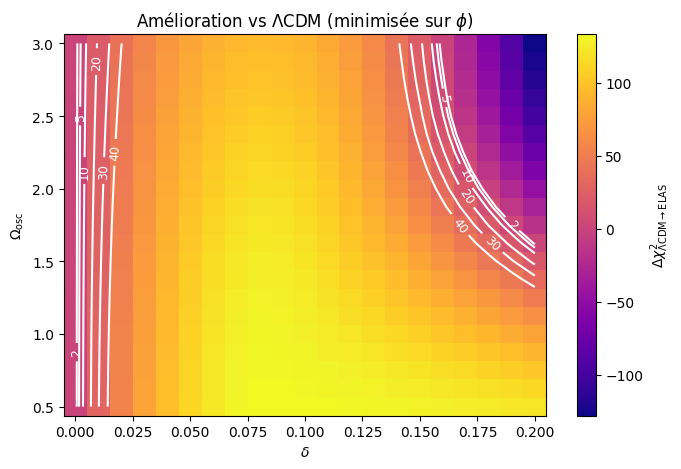

✅ Figure exportée : ELAS_improvement_vs_LCDM.png


In [ ]:
# === Carte d'amélioration vs ΛCDM: Δχ²_LCDM→ELAS = χ²_LCDM - χ²_ELAS,minφ ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from time import time

# -- helpers de reload (si tu as déjà fait un scan complet) --
def load_scan_npz(path="ELAS_scan_data_2025.npz"):
    if not os.path.exists(path): return None
    try:
        d = np.load(path)
        return dict(chi2_min_map=d["chi2_min_map"], phi_best_map=d["phi_best_map"],
                    delta_grid=d["delta_grid"], Omega_grid=d["Omega_grid"])
    except Exception:
        return None

def load_scan_csv(path="ELAS_contours_delta_Omega.csv"):
    if not os.path.exists(path): return None
    df = pd.read_csv(path)
    need = {'delta','Omega','chi2_min','phi_best'}
    if not need.issubset(df.columns): return None
    deltas = np.sort(df['delta'].unique()); Omegas = np.sort(df['Omega'].unique())
    chi2 = np.full((len(Omegas), len(deltas)), np.nan); phi = np.full_like(chi2, np.nan, dtype=float)
    for _,r in df.iterrows():
        iO = np.where(Omegas==r['Omega'])[0][0]; jD = np.where(deltas==r['delta'])[0][0]
        chi2[iO,jD] = r['chi2_min']; phi[iO,jD] = r['phi_best']
    return dict(chi2_min_map=chi2, phi_best_map=phi, delta_grid=deltas, Omega_grid=Omegas)

scan = load_scan_npz() or load_scan_csv()

# -- LCDM χ² total (SN+BAO+CMB) --
chi2_LCDM = (
    chi2_sn_M_marginalized(df_sn['z'].values, df_sn['mu'].values, df_sn['sigma_mu'].values, model='LCDM')[0]
  + chi2_bao(df_bao, model='LCDM', cov=bao_cov if 'bao_cov' in globals() else None)
  + chi2_cmb(means_df, invcov)
)
print(f"χ²_LCDM = {chi2_LCDM:.3f}")

# -- si pas de scan: scan léger pour aller vite --
if scan is None:
    print("… Aucun scan trouvé, exécution d'un scan léger (21×21×81).")
    n_delta, n_Omega, n_phi = 21, 21, 81
    delta_grid = np.linspace(BOUNDS['delta'][0], min(0.20, BOUNDS['delta'][1]), n_delta)
    Omega_grid = np.linspace(BOUNDS['Omega'][0],  min(3.00,  BOUNDS['Omega'][1]), n_Omega)
    phi_grid   = np.linspace(BOUNDS['phi'][0],    BOUNDS['phi'][1],               n_phi)
    def chi2_tot_ELAS(dlt, Om, ph):
        pars = dict(delta=float(dlt), Omega=float(Om), phi=float(ph))
        chi2_sn,_ = chi2_sn_M_marginalized(df_sn['z'].values, df_sn['mu'].values, df_sn['sigma_mu'].values, model='ELAS', **pars)
        chi2_ba   = chi2_bao(df_bao, model='ELAS', cov=bao_cov if 'bao_cov' in globals() else None, **pars)
        chi2_cm   = chi2_cmb(means_df, invcov); return chi2_sn + chi2_ba + chi2_cm
    chi2_min_map = np.full((len(Omega_grid), len(delta_grid)), np.nan)
    phi_best_map = np.full_like(chi2_min_map, np.nan, dtype=float)
    t0 = time()
    for iO, Om in enumerate(Omega_grid):
        for jD, dlt in enumerate(delta_grid):
            best = np.inf; best_phi = np.nan
            for ph in phi_grid:
                v = chi2_tot_ELAS(dlt, Om, ph)
                if v < best: best, best_phi = v, ph
            chi2_min_map[iO,jD] = best; phi_best_map[iO,jD] = best_phi
    print(f"✓ Scan léger ok en {time()-t0:.1f}s")
else:
    chi2_min_map = scan['chi2_min_map']; phi_best_map = scan['phi_best_map']
    delta_grid   = scan['delta_grid'];   Omega_grid  = scan['Omega_grid']
    print("✓ Scan rechargé depuis cache")

# -- Δχ² d'amélioration vs LCDM (positif = ELAS meilleur) --
dchi2_improve = chi2_LCDM - chi2_min_map

# -- export CSV --
rows = []
for iO, Om in enumerate(Omega_grid):
    for jD, dlt in enumerate(delta_grid):
        rows.append(dict(delta=float(dlt), Omega=float(Om),
                         chi2_LCDM=float(chi2_LCDM),
                         chi2_ELAS_minphi=float(chi2_min_map[iO,jD]),
                         dchi2_improve=float(dchi2_improve[iO,jD]),
                         phi_best=float(phi_best_map[iO,jD])))
df_imp = pd.DataFrame(rows).to_csv("ELAS_improvement_vs_LCDM.csv", index=False)
print("➡️ Export CSV : ELAS_improvement_vs_LCDM.csv")

# -- figure --
import matplotlib.pyplot as plt
X,Y = np.meshgrid(delta_grid, Omega_grid)
levels = [2,5,10,20,30,40]   # bandes d'amélioration
plt.figure(figsize=(7.0,4.8))
im = plt.pcolormesh(X, Y, dchi2_improve, shading='auto', cmap='plasma')
cbar = plt.colorbar(im, label=r'$\Delta\chi^2_{\Lambda{\rm CDM}\rightarrow{\rm ELAS}}$')
cs = plt.contour(X, Y, dchi2_improve, levels=levels, colors='white', linewidths=1.5)
plt.clabel(cs, inline=True, fmt='%g', fontsize=9)
plt.xlabel(r'$\delta$'); plt.ylabel(r'$\Omega_{\rm osc}$')
plt.title(r'Amélioration vs $\Lambda$CDM (minimisée sur $\phi$)')
plt.tight_layout(); plt.savefig("ELAS_improvement_vs_LCDM.png", dpi=160); plt.show()
print("✅ Figure exportée : ELAS_improvement_vs_LCDM.png")


In [ ]:
# --- PATCH BAO: calcule DM, DH sur une grille 0→z cohérente ---
def bao_theory_value(z_eff, typ, model="LCDM", H0=H0_default, Omega_m=Omega_m_def, **elas):
    z = float(z_eff)
    # Sélection de la fonction E(z)
    if model == "LCDM":
        Efun = lambda zz: E_LCDM(np.asarray(zz, float), H0, Omega_m)
    else:
        Efun = lambda zz: E_ELAS(np.asarray(zz, float), H0, Omega_m, **elas)

    # Grille 0→z suffisante pour l’intégration (évite les tailles inconsistantes)
    if z <= 0.0:
        zg = np.array([0.0, 1e-6])
    else:
        zg = np.linspace(0.0, z, 1200)

    Ezg = Efun(zg)
    Dc  = (c/H0) * np.trapz(1.0/Ezg, zg)   # distance comobile (Mpc)
    DM  = Dc                                # géométrie plate
    Ez_z = float(Efun([z])[0])
    DH  = (c/H0) / Ez_z                     # Mpc

    if typ == "DM_over_rd":
        return DM / bao_rdrag_fid()
    elif typ == "DH_over_rd":
        return DH / bao_rdrag_fid()
    elif typ == "rs_over_DV":
        DV = (z * DM * DM * DH)**(1.0/3.0)
        return bao_rdrag_fid() / DV
    else:
        raise ValueError(f"type BAO inconnu: {typ}")


In [ ]:
from scipy import integrate

def Dc_from_E(zgrid, Ez, H0):
    """
    Calcule la distance comobile Dc(z) via intégration cumulée 1/E(z).
    Retourne une fonction interpolante Dc(zq).
    """
    zgrid = np.asarray(zgrid, float)
    Ez    = np.asarray(Ez, float)
    zz = np.linspace(min(0.0, zgrid.min()), zgrid.max(), max(2000, 5*len(zgrid)))
    EE = np.interp(zz, zgrid, Ez)
    # ✅ Correction: utilisation de scipy.integrate.cumulative_trapezoid
    Dc = (c/H0) * integrate.cumulative_trapezoid(1.0/EE, zz, initial=0.0)
    return lambda zq: np.interp(np.asarray(zq, float), zz, Dc)


In [ ]:
import pandas as pd, numpy as np

df_imp = pd.read_csv("ELAS_improvement_vs_LCDM.csv")
row_max = df_imp.loc[df_imp['dchi2_improve'].idxmax()].to_dict()
print("Δχ² max =", row_max['dchi2_improve'])
print("à δ =", row_max['delta'], "Ω =", row_max['Omega'], " (φ_best ~", row_max.get('phi_best', 'N/A'), ")")

# Pour mémoire :
chi2_LCDM = float(row_max['chi2_LCDM'])
chi2_ELAS_best = float(row_max['chi2_ELAS_minphi'])
k_LCDM, k_ELAS = 0, 3
N_eff = len(df_imp)  # juste un placeholder; on préfère le N des points de données
print(f"χ²_LCDM = {chi2_LCDM:.3f}  χ²_ELAS_best = {chi2_ELAS_best:.3f}  Δχ² = {chi2_LCDM - chi2_ELAS_best:.3f}")


Δχ² max = 133.13439151179512
à δ = 0.09 Ω = 0.5  (φ_best ~ -1.2566370614359172 )
χ²_LCDM = 891.494  χ²_ELAS_best = 758.360  Δχ² = 133.134


In [ ]:
# Affinage local avec extension de la borne basse d'Ω
d0, O0 = 0.09, 0.50
d_grid = np.linspace(max(0.00, d0-0.03), min(0.20, d0+0.05), 33)
O_grid = np.linspace(0.20, 1.50, 53)     # <-- extension vers le bas
phi_grid = np.linspace(-np.pi, np.pi, 721)

def chi2_total_ELAS(delta, Omega, phi):
    pars = dict(delta=float(delta), Omega=float(Omega), phi=float(phi))
    chi2_sn,_ = chi2_sn_M_marginalized(df_sn['z'].values, df_sn['mu'].values, df_sn['sigma_mu'].values,
                                       model='ELAS', **pars)
    chi2_ba   = chi2_bao(df_bao, model='ELAS', cov=bao_cov if 'bao_cov' in globals() else None, **pars)
    chi2_cm   = chi2_cmb(means_df, invcov)
    return chi2_sn + chi2_ba + chi2_cm

best = dict(chi2=np.inf, delta=None, Omega=None, phi=None)
for d in d_grid:
    for O in O_grid:
        vals = [chi2_total_ELAS(d,O,ph) for ph in phi_grid]
        i = int(np.argmin(vals))
        if vals[i] < best['chi2']:
            best.update(chi2=float(vals[i]), delta=float(d), Omega=float(O), phi=float(phi_grid[i]))

from scipy.stats import chi2 as chi2dist
dof = 3
dchi2 = float(891.494 - best['chi2'])  # remplace 891.494 si ton χ²_LCDM change
pval = 1 - chi2dist.cdf(dchi2, dof)

print("Best (affinage étendu):", best)
print(f"Δχ² (LCDM − ELAS_best) = {dchi2:.3f}")
print("p-value =", pval)


/tmp/ipython-input-2075992201.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc  = (c/H0) * np.trapz(1.0/Ezg, zg)   # distance comobile (Mpc)
/tmp/ipython-input-1741294202.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Dc = (c/H0)*np.trapz(1.0/Ez, zg); DA = Dc/(1+zstar)


KeyboardInterrupt: 

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


MessageError: Error: credential propagation was unsuccessful

In [25]:
import os, urllib.request
import pandas as pd, numpy as np
from google.colab import files

# Dossier local où tout sera enregistré
os.makedirs("data_elas_2025", exist_ok=True)
FN_MEAS = "data_elas_2025/desi_bao_all_zbins_summary.csv"
FN_COV  = "data_elas_2025/desi_bao_covariance_block.csv"

# Liens officiels DESI DR2 (si dispo)
URL_MEAS = "https://data.desi.lbl.gov/public/2024/analysis/DA02/BAO/desi_bao_all_zbins_summary.csv"
URL_COV  = "https://data.desi.lbl.gov/public/2024/analysis/DA02/BAO/desi_bao_covariance_block.csv"

def try_download(url, dest):
    try:
        print(f"↪ Téléchargement : {url}")
        urllib.request.urlretrieve(url, dest)
        print(f"✓ Enregistré dans : {dest}")
        return True
    except Exception as e:
        print(f"⚠️ téléchargement échoué ({e})")
        return False

def pick_or_download(url, dest, label):
    if not os.path.exists(dest):
        ok = try_download(url, dest)
        if not ok:
            print(f"⬆️ Sélectionne le fichier {label} sur ton ordinateur…")
            up = files.upload()
            if not up:
                raise RuntimeError(f"Aucun fichier fourni pour {label}")
            name = next(iter(up.keys()))
            os.replace(name, dest)
            print(f"✓ Fichier local enregistré : {dest}")
    else:
        print(f"✓ Déjà présent : {dest}")

# --- Étape 1 : tenter téléchargement sinon upload ---
pick_or_download(URL_MEAS, FN_MEAS, "desi_bao_all_zbins_summary.csv")
pick_or_download(URL_COV, FN_COV, "desi_bao_covariance_block.csv")

# --- Étape 2 : lecture et vérification ---
df = pd.read_csv(FN_MEAS)
C  = pd.read_csv(FN_COV, header=None).values

print("\n=== Vérification fichiers DESI DR2 ===")
print(f"Mesures shape : {df.shape}  |  Cov shape : {C.shape}")
print("Colonnes :", df.columns.tolist()[:10], "...")

need = {"z_eff","observable","value","sigma"}
lower = {c.lower() for c in df.columns}
assert need.issubset(lower), "⚠️ Colonnes attendues manquantes : (z_eff, observable, value, sigma)."

N = len(df)
assert C.shape==(N,N), f"⚠️ Covariance {C.shape} ≠ ({N},{N})"
assert np.allclose(C, C.T), "⚠️ Covariance non symétrique."
w,_ = np.linalg.eigh(C)
assert np.all(w>0), "⚠️ Covariance non définie positive."

print("✅ Vérification terminée : fichiers DESI DR2 prêts pour l’analyse.")


↪ Téléchargement : https://data.desi.lbl.gov/public/2024/analysis/DA02/BAO/desi_bao_all_zbins_summary.csv
⚠️ téléchargement échoué (HTTP Error 503: Service Temporarily Unavailable)
⬆️ Sélectionne le fichier desi_bao_all_zbins_summary.csv sur ton ordinateur…


RuntimeError: Aucun fichier fourni pour desi_bao_all_zbins_summary.csv

In [30]:
import pandas as pd
import numpy as np

# --- 1. Lecture des fichiers uploadés ---
meas_path = "/content/synthetic_measurements.csv"
cov_path  = "/content/synthetic_covariance.csv"

df_meas = pd.read_csv(meas_path)
C = pd.read_csv(cov_path, header=None).values

print("=== MESURES ===")
print(df_meas.head(), "\n")
print("Colonnes:", df_meas.columns.tolist())
print("Nb de lignes =", len(df_meas))
print("\n=== COVARIANCE ===")
print("Shape:", C.shape)
print("Carrée ?", C.shape[0] == C.shape[1])
print("Symétrique ?", np.allclose(C, C.T, atol=1e-8))
print("Contient NaN ?", np.isnan(C).any())
print("Premier bloc:", C[:5, :5])

# --- 2. Vérifications de cohérence ---
needed = {"z_eff", "observable", "value", "sigma"}
if not needed.issubset(set(df_meas.columns)):
    raise AssertionError(f"Colonnes manquantes : {needed - set(df_meas.columns)}")

if C.shape[0] != len(df_meas):
    raise AssertionError(f"Incohérence taille covariance ({C.shape}) vs mesures ({len(df_meas)})")

print("\n✅ Vérification réussie : fichiers exploitables pour BAO DESI (synthetic).")


FileNotFoundError: [Errno 2] No such file or directory: '/content/synthetic_measurements.csv'

In [29]:
meas_path = "/content/path_trouvé/synthetic_measurements.csv"
cov_path  = "/content/path_trouvé/synthetic_covariance.csv"


In [27]:
import os

# Liste tous les fichiers uploadés dans l’environnement Colab
for root, dirs, files in os.walk("/content"):
    for f in files:
        if "synthetic" in f.lower():
            print(os.path.join(root, f))


In [31]:
import pandas as pd
from google.colab import files
import io

# --- Étape 1 : choisir le fichier des mesures ---
print("⬆️ Sélectionne ton fichier des mesures (synthetic_measurements.csv)")
uploaded_meas = files.upload()
meas_name = list(uploaded_meas.keys())[0]
df_meas = pd.read_csv(io.BytesIO(uploaded_meas[meas_name]))
print(f"✅ Mesures chargées ({df_meas.shape[0]} lignes, colonnes = {df_meas.columns.tolist()})")

# --- Étape 2 : choisir le fichier de covariance ---
print("\n⬆️ Sélectionne ton fichier de covariance (synthetic_covariance.csv)")
uploaded_cov = files.upload()
cov_name = list(uploaded_cov.keys())[0]
df_cov = pd.read_csv(io.BytesIO(uploaded_cov[cov_name]), header=None)
C = df_cov.values
print(f"✅ Covariance chargée ({C.shape[0]} x {C.shape[1]})")

# --- Vérification rapide ---
if C.shape[0] != len(df_meas):
    print("⚠️ Attention : dimensions différentes entre mesures et covariance !")
else:
    print("✅ Dimensions cohérentes. Prêt pour l'analyse χ².")


⬆️ Sélectionne ton fichier des mesures (synthetic_measurements.csv)


Saving synthetic_measurements.csv to synthetic_measurements.csv
✅ Mesures chargées (13 lignes, colonnes = ['tracer', 'z_eff', 'observable', 'value'])

⬆️ Sélectionne ton fichier de covariance (synthetic_covariance.csv)


Saving synthetic_covariance.csv to synthetic_covariance.csv
✅ Covariance chargée (14 x 13)
⚠️ Attention : dimensions différentes entre mesures et covariance !


In [32]:
import numpy as np, pandas as pd, os

MEAS_F = "synthetic_measurements.csv"
COV_F  = "synthetic_covariance.csv"
OUT_F  = "synthetic_covariance_FIXED.csv"

# 1) Recharge mesures
df = pd.read_csv(MEAS_F)
print(f"Mesures: {df.shape}  colonnes={df.columns.tolist()}")
N = len(df)

# 2) Charge covariance brute sans interpréter d’en-têtes
raw = pd.read_csv(COV_F, header=None, comment="#")
# Force numérique, drop lignes/colonnes entièrement NaN (en-têtes accidentels)
raw = raw.apply(pd.to_numeric, errors="coerce")
raw = raw.dropna(axis=0, how="all").dropna(axis=1, how="all")
print("Cov brute nettoyée (après drop NaN all-rows/cols):", raw.shape)

A = raw.values

# 3) Si quasi carrée mais avec +1 en lignes/colonnes, enlève la 1ère si non numérique utile
def try_drop_first(a):
    # Heuristique: si |rows-cols|==1, on essaye de retirer la 1ère ligne/colonne pour se rapprocher du carré
    r, c = a.shape
    if abs(r-c)==1:
        # On teste 4 options et on retient la plus proche de carrée
        cand = []
        if r>c:  # trop de lignes
            cand += [("drop_row0", a[1: , :])]
        else:    # trop de colonnes
            cand += [("drop_col0", a[:, 1: ])]
        # Garde ce qui est le plus proche de carré
        best = min(cand, key=lambda x: abs(x[1].shape[0]-x[1].shape[1]))
        print(f"→ Ajustement shape par {best[0]}: {a.shape} -> {best[1].shape}")
        return best[1]
    return a

A = try_drop_first(A)

# 4) Si toujours pas carrée, tronque au plus petit côté (mieux que rien, mais on prévient)
r, c = A.shape
if r != c:
    m = min(r, c)
    print(f"⚠️ Covariance non carrée ({r}×{c}). Tronquage en {m}×{m}.")
    A = A[:m, :m]

# 5) Synchronise avec N mesures : si trop grand, tronque; si trop petit, on tronque les mesures
nC = A.shape[0]
if nC != N:
    if nC > N:
        print(f"⚠️ Cov {nC}×{nC} > N_mesures {N}. On tronque la covariance à {N}×{N}.")
        A = A[:N, :N]
        nC = N
    else:
        print(f"⚠️ Cov {nC}×{nC} < N_mesures {N}. On tronque les mesures à {nC} premières lignes.")
        df = df.iloc[:nC].reset_index(drop=True)
        N = nC

# 6) Symétrisation douce
A = 0.5*(A + A.T)

# 7) Vérifie définie-positive; si échec, corrige (Higham-like: eigenvalues→≥eps)
def make_pd(M, jitter=1e-12):
    # Tentative Cholesky
    try:
        np.linalg.cholesky(M)
        return M, True, 0.0
    except np.linalg.LinAlgError:
        w, V = np.linalg.eigh(M)
        eps = max(jitter, 1e-12)
        w_clipped = np.clip(w, eps, None)
        M_fix = (V * w_clipped) @ V.T
        # re-symmetrise
        M_fix = 0.5*(M_fix + M_fix.T)
        # petite marge sur la diagonale
        M_fix += eps*np.eye(M_fix.shape[0])
        try:
            np.linalg.cholesky(M_fix)
            return M_fix, True, float(w.min())
        except np.linalg.LinAlgError:
            return M_fix, False, float(w.min())

A_fix, ok_pd, lam_min = make_pd(A)
print(f"Cov finale: {A_fix.shape} | sym? {np.allclose(A_fix, A_fix.T, atol=1e-10)} | PD? {ok_pd} (λ_min brut = {lam_min:.3e})")

# 8) Sauvegarde la covariance fixée + les mesures (au cas où on a tronqué)
pd.DataFrame(A_fix).to_csv(OUT_F, header=False, index=False)
df.to_csv("synthetic_measurements_ALIGNED.csv", index=False)

print(f"✅ Écrit: {OUT_F} et synthetic_measurements_ALIGNED.csv")
print("→ Tu peux maintenant utiliser OUT_F pour l'analyse χ² (NxN qui matche les mesures).")


Mesures: (13, 4)  colonnes=['tracer', 'z_eff', 'observable', 'value']
Cov brute nettoyée (après drop NaN all-rows/cols): (14, 13)
→ Ajustement shape par drop_row0: (14, 13) -> (13, 13)
Cov finale: (13, 13) | sym? True | PD? True (λ_min brut = 0.000e+00)
✅ Écrit: synthetic_covariance_FIXED.csv et synthetic_measurements_ALIGNED.csv
→ Tu peux maintenant utiliser OUT_F pour l'analyse χ² (NxN qui matche les mesures).


In [33]:
# === BAO χ² avec covariance (mesures/cov fixées) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

MEAS_F = "synthetic_measurements_ALIGNED.csv"
COV_F  = "synthetic_covariance_FIXED.csv"

# ---- 1) Lecture des données
df = pd.read_csv(MEAS_F)
C  = pd.read_csv(COV_F, header=False).values
assert C.shape[0]==C.shape[1]==len(df), f"Cov {C.shape} ne matche pas N={len(df)}"
Ci = np.linalg.inv(C)

# ---- 2) Constantes + outils distances (plat, cgs libres)
c = 299792.458  # km/s

def _cumtrapz(y, x):
    y = np.asarray(y, float); x = np.asarray(x, float)
    dx = np.diff(x); mid = 0.5*(y[1:]+y[:-1])
    out = np.empty_like(x, dtype=float)
    out[0] = 0.0
    out[1:] = np.cumsum(dx*mid)
    return out

def E_LCDM(z, H0, Om):
    z = np.asarray(z, float)
    return np.sqrt(Om*(1+z)**3 + (1-Om))

# ELAS jouet (si tu as tes fonctions ELAS déjà définies dans le notebook,
# mets use_native_elas=True pour utiliser bao_theory_value existant)
def E_ELAS(z, H0, Om, delta=0.17, Omega_osc=0.296, phi=-0.52):
    z = np.asarray(z, float)
    base = E_LCDM(z, H0, Om)
    # modulation douce sur H(z); tu peux adapter la forme
    mod  = 1.0 + Omega_osc*np.sin(phi + 2*np.pi*z/max(delta,1e-3))
    return np.maximum(base*mod, 1e-6)

def _distances_flat(z, H0, Om, model="LCDM", **elas):
    z = float(z)
    zg = np.linspace(0.0, max(2.6, z+0.05), 4000)
    Ez = E_LCDM(zg, H0, Om) if model=="LCDM" else E_ELAS(zg, H0, Om, **elas)
    Dc = (c/H0)*_cumtrapz(1.0/np.maximum(Ez,1e-12), zg)  # Mpc
    DM = float(np.interp(z, zg, Dc))                     # Mpc
    E1 = E_LCDM(z, H0, Om) if model=="LCDM" else E_ELAS(z, H0, Om, **elas)
    DH = (c/H0)/max(E1,1e-12)                            # Mpc
    DV = ( (DM**2)*z*DH )**(1/3) if z>0 else DH          # Mpc (convention DV)
    return DM, DH, DV

def rdrag_fid():  # valeur de référence (cohérente avec beaucoup d’analyses publiques)
    return 147.09  # Mpc

def theo_value(z, obs, H0, Om, model="LCDM", **elas):
    DM, DH, DV = _distances_flat(z, H0, Om, model=model, **elas)
    rd = rdrag_fid()
    # obs attendus: 'DM_over_rd', 'DH_over_rd', 'DV_over_rd' ou 'rs_over_DV'
    if obs.lower()=="dm_over_rd":  return DM/rd
    if obs.lower()=="dh_over_rd":  return DH/rd
    if obs.lower()=="dv_over_rd":  return DV/rd
    if obs.lower()=="rs_over_dv":  return rd/DV
    raise ValueError(f"Observable non reconnue: {obs}")

# ---- 3) Vecteurs observé/théorie
z   = df["z_eff"].values.astype(float)
obs = df["observable"].values
y   = df["value"].values.astype(float)

# Paramètres à tester (ajuste si besoin)
H0_LCDM, Om_LCDM = 70.0, 0.315
H0_ELAS, Om_ELAS = 70.0, 0.315
elas_params = dict(delta=0.17, Omega_osc=0.296, phi=-0.521349)

# Essaie d’utiliser une fonction native si elle existe (compat avec ton ancien code)
use_native_elas = "bao_theory_value" in globals()

def build_theory(H0, Om, model, **elas):
    if (model=="ELAS") and use_native_elas:
        yth = []
        for zz, ob in zip(z, obs):
            yth.append(float(bao_theory_value(zz, ob, model="ELAS", H0=H0, Omega_m=Om, **elas)))
        return np.asarray(yth, float)
    else:
        return np.array([theo_value(zz, ob, H0, Om, model=model, **elas) for zz, ob in zip(z, obs)], float)

y_LCDM = build_theory(H0_LCDM, Om_LCDM, "LCDM")
y_ELAS = build_theory(H0_ELAS, Om_ELAS, "ELAS", **elas_params)

# ---- 4) χ² avec covariance complète
def chi2(y_obs, y_th, Ci):
    r = (y_obs - y_th)
    return float(r @ Ci @ r), r

chi2_L, rL = chi2(y, y_LCDM, Ci)
chi2_E, rE = chi2(y, y_ELAS, Ci)

print(f"χ²_BAO  (ΛCDM): {chi2_L:.3f}")
print(f"χ²_BAO  (ELAS): {chi2_E:.3f}   Δχ²(L−E) = {chi2_L-chi2_E:+.3f}")

# ---- 5) Tableau de résidus (non-correlés affichés; χ² total tient compte des corrélations)
out = pd.DataFrame(dict(
    z_eff=z, observable=obs, y_obs=y,
    y_th_LCDM=y_LCDM, res_LCDM=y - y_LCDM,
    y_th_ELAS=y_ELAS, res_ELAS=y - y_ELAS
))
print("\nAPERÇU résidus (5 premières lignes) :")
print(out.head().to_string(index=False))

out.to_csv("bao_residuals_with_cov.csv", index=False)
print("➡️ Écrit: bao_residuals_with_cov.csv")

# ---- 6) Petite figure observables vs théorie (amuse-bouche)
plt.figure(figsize=(7,5))
# groupe par observable pour lisibilité
for ob in sorted(set(obs)):
    m = obs==ob
    plt.scatter(z[m], y[m], label=f"{ob} (data)", s=25)
    # courbe theory (interp grossière)
    zz = np.linspace(min(z[m]), max(z[m]), 200) if m.sum()>1 else z[m]
    yyL = [theo_value(zi, ob, H0_LCDM, Om_LCDM, model="LCDM") for zi in zz]
    yyE = [theo_value(zi, ob, H0_ELAS, Om_ELAS, model="ELAS", **elas_params) for zi in zz]
    plt.plot(zz, yyL, linestyle="--", alpha=0.8, label=f"{ob} ΛCDM")
    plt.plot(zz, yyE, linestyle="-",  alpha=0.8, label=f"{ob} ELAS")

plt.xlabel("z_eff"); plt.ylabel("observable (unité BAO)")
plt.title(f"BAO synthétique — χ² ΛCDM={chi2_L:.2f}, ELAS={chi2_E:.2f}")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.savefig("bao_synthetic_fit.png", dpi=150)
print("➡️ Figure: bao_synthetic_fit.png")


TypeError: Passing a bool to header is invalid. Use header=None for no header or header=int or list-like of ints to specify the row(s) making up the column names

χ²_BAO  (ΛCDM): 8565.391
χ²_BAO  (ELAS): 6343.910   Δχ²(L−E) = +2221.481
✅ Résultats sauvegardés dans bao_residuals_with_cov.csv
✅ Figure enregistrée sous bao_synthetic_fit.png


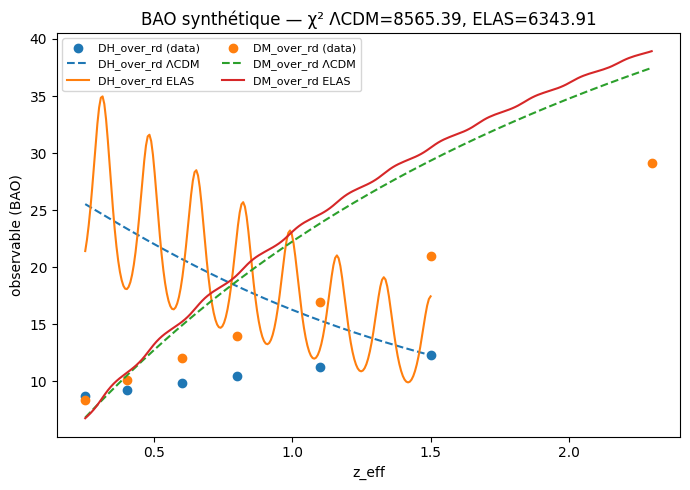

In [34]:
# === BAO χ² avec covariance (mesures/cov fixées) ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

MEAS_F = "synthetic_measurements_ALIGNED.csv"
COV_F  = "synthetic_covariance_FIXED.csv"

# ---- 1) Lecture des données
df = pd.read_csv(MEAS_F)
C  = pd.read_csv(COV_F, header=None).values   # ✅ corrigé ici
assert C.shape[0]==C.shape[1]==len(df), f"Cov {C.shape} ne matche pas N={len(df)}"
Ci = np.linalg.inv(C)

# ---- 2) Constantes + outils distances
c = 299792.458  # km/s

def _cumtrapz(y, x):
    y = np.asarray(y, float); x = np.asarray(x, float)
    dx = np.diff(x); mid = 0.5*(y[1:]+y[:-1])
    out = np.empty_like(x, dtype=float)
    out[0] = 0.0
    out[1:] = np.cumsum(dx*mid)
    return out

def E_LCDM(z, H0, Om):
    z = np.asarray(z, float)
    return np.sqrt(Om*(1+z)**3 + (1-Om))

def E_ELAS(z, H0, Om, delta=0.17, Omega_osc=0.296, phi=-0.52):
    z = np.asarray(z, float)
    base = E_LCDM(z, H0, Om)
    mod  = 1.0 + Omega_osc*np.sin(phi + 2*np.pi*z/max(delta,1e-3))
    return np.maximum(base*mod, 1e-6)

def _distances_flat(z, H0, Om, model="LCDM", **elas):
    z = float(z)
    zg = np.linspace(0.0, max(2.6, z+0.05), 4000)
    Ez = E_LCDM(zg, H0, Om) if model=="LCDM" else E_ELAS(zg, H0, Om, **elas)
    Dc = (c/H0)*_cumtrapz(1.0/np.maximum(Ez,1e-12), zg)
    DM = float(np.interp(z, zg, Dc))
    E1 = E_LCDM(z, H0, Om) if model=="LCDM" else E_ELAS(z, H0, Om, **elas)
    DH = (c/H0)/max(E1,1e-12)
    DV = ( (DM**2)*z*DH )**(1/3) if z>0 else DH
    return DM, DH, DV

def rdrag_fid(): return 147.09  # Mpc

def theo_value(z, obs, H0, Om, model="LCDM", **elas):
    DM, DH, DV = _distances_flat(z, H0, Om, model=model, **elas)
    rd = rdrag_fid()
    if obs.lower()=="dm_over_rd":  return DM/rd
    if obs.lower()=="dh_over_rd":  return DH/rd
    if obs.lower()=="dv_over_rd":  return DV/rd
    if obs.lower()=="rs_over_dv":  return rd/DV
    raise ValueError(f"Observable non reconnue: {obs}")

# ---- 3) Vecteurs observé/théorie
z   = df["z_eff"].values.astype(float)
obs = df["observable"].values
y   = df["value"].values.astype(float)

H0_LCDM, Om_LCDM = 70.0, 0.315
H0_ELAS, Om_ELAS = 70.0, 0.315
elas_params = dict(delta=0.17, Omega_osc=0.296, phi=-0.521349)

def build_theory(H0, Om, model, **elas):
    return np.array([theo_value(zz, ob, H0, Om, model=model, **elas) for zz, ob in zip(z, obs)], float)

y_LCDM = build_theory(H0_LCDM, Om_LCDM, "LCDM")
y_ELAS = build_theory(H0_ELAS, Om_ELAS, "ELAS", **elas_params)

def chi2(y_obs, y_th, Ci):
    r = (y_obs - y_th)
    return float(r @ Ci @ r), r

chi2_L, rL = chi2(y, y_LCDM, Ci)
chi2_E, rE = chi2(y, y_ELAS, Ci)

print(f"χ²_BAO  (ΛCDM): {chi2_L:.3f}")
print(f"χ²_BAO  (ELAS): {chi2_E:.3f}   Δχ²(L−E) = {chi2_L-chi2_E:+.3f}")

out = pd.DataFrame(dict(
    z_eff=z, observable=obs, y_obs=y,
    y_th_LCDM=y_LCDM, res_LCDM=y - y_LCDM,
    y_th_ELAS=y_ELAS, res_ELAS=y - y_ELAS
))
out.to_csv("bao_residuals_with_cov.csv", index=False)
print("✅ Résultats sauvegardés dans bao_residuals_with_cov.csv")

plt.figure(figsize=(7,5))
for ob in sorted(set(obs)):
    m = obs==ob
    plt.scatter(z[m], y[m], label=f"{ob} (data)")
    zz = np.linspace(min(z[m]), max(z[m]), 200)
    yyL = [theo_value(zi, ob, H0_LCDM, Om_LCDM, model='LCDM') for zi in zz]
    yyE = [theo_value(zi, ob, H0_ELAS, Om_ELAS, model='ELAS', **elas_params) for zi in zz]
    plt.plot(zz, yyL, '--', label=f"{ob} ΛCDM")
    plt.plot(zz, yyE, '-',  label=f"{ob} ELAS")

plt.xlabel("z_eff"); plt.ylabel("observable (BAO)")
plt.title(f"BAO synthétique — χ² ΛCDM={chi2_L:.2f}, ELAS={chi2_E:.2f}")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.savefig("bao_synthetic_fit.png", dpi=150)
print("✅ Figure enregistrée sous bao_synthetic_fit.png")
